In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import random
import csv
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime

In [2]:
#Get list of s&p 500 companies 
file = open("s&p500-list.csv")
reader = csv.DictReader(file)
symbols = [row['Symbol'] for row in reader]
file.close()
print(symbols[:16])

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN']


In [3]:
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day) #5 years back

#Pick any companies from the list (showing a subset to speed up processing time)
stocks_list = ['ADI', 'AMD', 'NVDA', 'IBM', 'ON']

"""Note: can also take a random sample of n companies by running:
stocks_list = random.sample(symbols, n) 
"""
df = yf.download(stocks_list, start, end)

df.info()

[*********************100%%**********************]  5 of 5 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-15 to 2024-01-12
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, ADI)   1258 non-null   float64
 1   (Adj Close, AMD)   1258 non-null   float64
 2   (Adj Close, IBM)   1258 non-null   float64
 3   (Adj Close, NVDA)  1258 non-null   float64
 4   (Adj Close, ON)    1258 non-null   float64
 5   (Close, ADI)       1258 non-null   float64
 6   (Close, AMD)       1258 non-null   float64
 7   (Close, IBM)       1258 non-null   float64
 8   (Close, NVDA)      1258 non-null   float64
 9   (Close, ON)        1258 non-null   float64
 10  (High, ADI)        1258 non-null   float64
 11  (High, AMD)        1258 non-null   float64
 12  (High, IBM)        1258 non-null   float64
 13  (High, NVDA)       1258 non-null   float64
 14  (High, ON)         1258 non-null   float64
 15  (Low, ADI)         1258 non-null   float64
 16  (Low, 

In [4]:
df.describe() 

Adj Close                                                      \
               ADI          AMD          IBM         NVDA           ON   
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean    140.961735    78.947742   116.529269   180.661662    46.665779   
std      31.840308    33.042573    15.786056   127.337067    25.348102   
min      76.735909    19.250000    75.172752    32.644455     8.450000   
25%     108.118233    52.352500   104.389013    71.684164    21.712499   
50%     148.128471    82.375000   115.675293   148.152321    41.885000   
75%     165.815250   102.805000   125.149405   234.116348    66.564997   
max     200.880005   161.910004   165.800003   548.219971   108.089996   

             Close                                                      ...  \
               ADI          AMD          IBM         NVDA           ON  ...   
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000  ...   
mean    146.885350    78.947742   130.638888   180.884390    46.665779  ...   
std      29.912340    33.042573    11.116010   127.287119    25.348102  ...   
min      82.230003    19.250000    90.602295    32.900002     8.450000  ...   
25%     116.012501    52.352500   123.243521    71.921247    21.712499  ...   
50%     154.334999    82.375000   130.850006   148.434998    41.885000  ...   
75%     170.815002   102.805000   137.133530   234.244999    66.564997  ...   
max     200.880005   161.910004   165.800003   548.219971   108.089996  ...   

              Open                                                      \
               ADI          AMD          IBM         NVDA           ON   
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean    146.831558    78.930048   130.591398   180.744320    46.629873   
std      29.874475    33.062088    11.066209   127.282416    25.309991   
min      82.440002    19.490000    90.439774    33.667500     8.360000   
25%     116.007500    52.314999   123.061880    71.168127    21.762500   
50%     154.599998    82.550003   130.747849   148.046249    42.055000   
75%     170.279999   102.295002   137.048973   234.937504    66.697500   
max     201.940002   163.279999   164.369995   549.989990   109.739998   

             Volume                                                          
                ADI           AMD           IBM          NVDA            ON  
count  1.258000e+03  1.258000e+03  1.258000e+03  1.258000e+03  1.258000e+03  
mean   3.180168e+06  6.607933e+07  4.949018e+06  4.612829e+07  6.904449e+06  
std    1.465982e+06  2.939996e+07  3.033578e+06  1.992966e+07  4.133998e+06  
min    4.664000e+05  1.670590e+07  1.257397e+06  9.788400e+06  1.224100e+06  
25%    2.283225e+06  4.537255e+07  3.321775e+06  3.239300e+07  4.682875e+06  
50%    2.942650e+06  5.817670e+07  4.203412e+06  4.284320e+07  6.097000e+06  
75%    3.735600e+06  7.996535e+07  5.541995e+06  5.597628e+07  8.138650e+06  
max    1.915640e+07  2.253941e+08  3.981442e+07  2.511528e+08  9.318090e+07  

[8 rows x 30 columns]

## Data preprocessing 
Fill spaces in null columns with the means of the ~10 entries (less if closer to top or bottom) above and below them.

In [5]:
def avg(series):
    for i in range(len(series)):
        if pd.isnull(series[i]):
            start = max(0, i - 10)
            end = min(len(series), i + 11)
            avg = series[start:end].mean()
            series[i] = avg
    return series

df = df.apply(avg, axis=0)
df.head()


/tmp/ipykernel_1926/1453454734.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isnull(series[i]):


Adj Close                                                  Close  \
                  ADI        AMD        IBM       NVDA         ON        ADI   
Date                                                                           
2019-01-15  79.675179  20.379999  91.186348  37.176464  17.840000  87.610001   
2019-01-16  79.120430  19.730000  91.103951  36.920975  17.629999  87.000000   
2019-01-17  80.766510  20.250000  91.530945  37.635368  17.820000  88.809998   
2019-01-18  83.085556  20.770000  92.751945  38.927765  18.410000  91.360001   
2019-01-22  81.057518  19.760000  91.778130  36.903603  17.760000  89.129997   

                                                         ...       Open  \
                  AMD         IBM       NVDA         ON  ...        ADI   
Date                                                     ...              
2019-01-15  20.379999  116.376671  37.467499  17.840000  ...  87.660004   
2019-01-16  19.730000  116.271507  37.209999  17.629999  ...  87.599998   
2019-01-17  20.250000  116.816444  37.930000  17.820000  ...  86.510002   
2019-01-18  20.770000  118.374763  39.232498  18.410000  ...  89.610001   
2019-01-22  19.760000  117.131927  37.192501  17.760000  ...  90.570000   

                                                          Volume            \
                  AMD         IBM       NVDA         ON      ADI       AMD   
Date                                                                         
2019-01-15  20.440001  115.640533  37.939999  17.820000  1960500  62785800   
2019-01-16  20.400000  116.233269  37.742500  17.900000  1667100  70849300   
2019-01-17  19.490000  115.258125  36.877499  17.440001  2563000  85018400   
2019-01-18  20.370001  117.848946  38.432499  17.900000  3471600  88131000   
2019-01-22  20.480000  117.877632  38.927502  18.180000  2749500  78513700   

                                         
                 IBM      NVDA       ON  
Date                                     
2019-01-15   3668845  61701200  4061200  
2019-01-16   4017791  47010400  3422800  
2019-01-17   5261275  49343600  6039700  
2019-01-18   6284891  65133600  5807700  
2019-01-22  10514810  66155200  5946900  

[5 rows x 30 columns]

## Data visualization
Use matplotlib to plot a variety of features, including adjusted close price (close price after adjustments are made for dividend payouts and stock splits as outlined in CRSP standards), daily return percentage and 10-day exponential moving average.

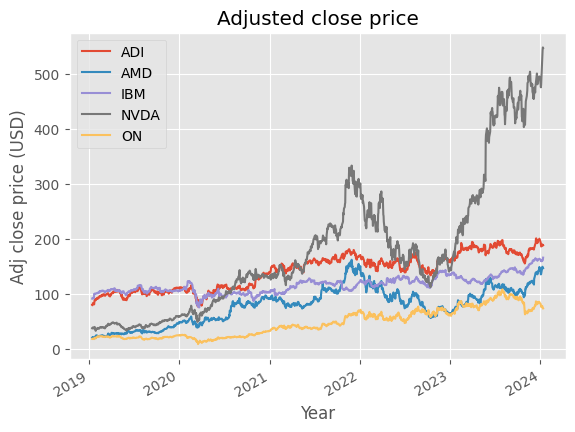

In [6]:
df['Adj Close'].plot(legend=True, title='Adjusted close price',xlabel='Year', ylabel='Adj close price (USD)')
plt.show()

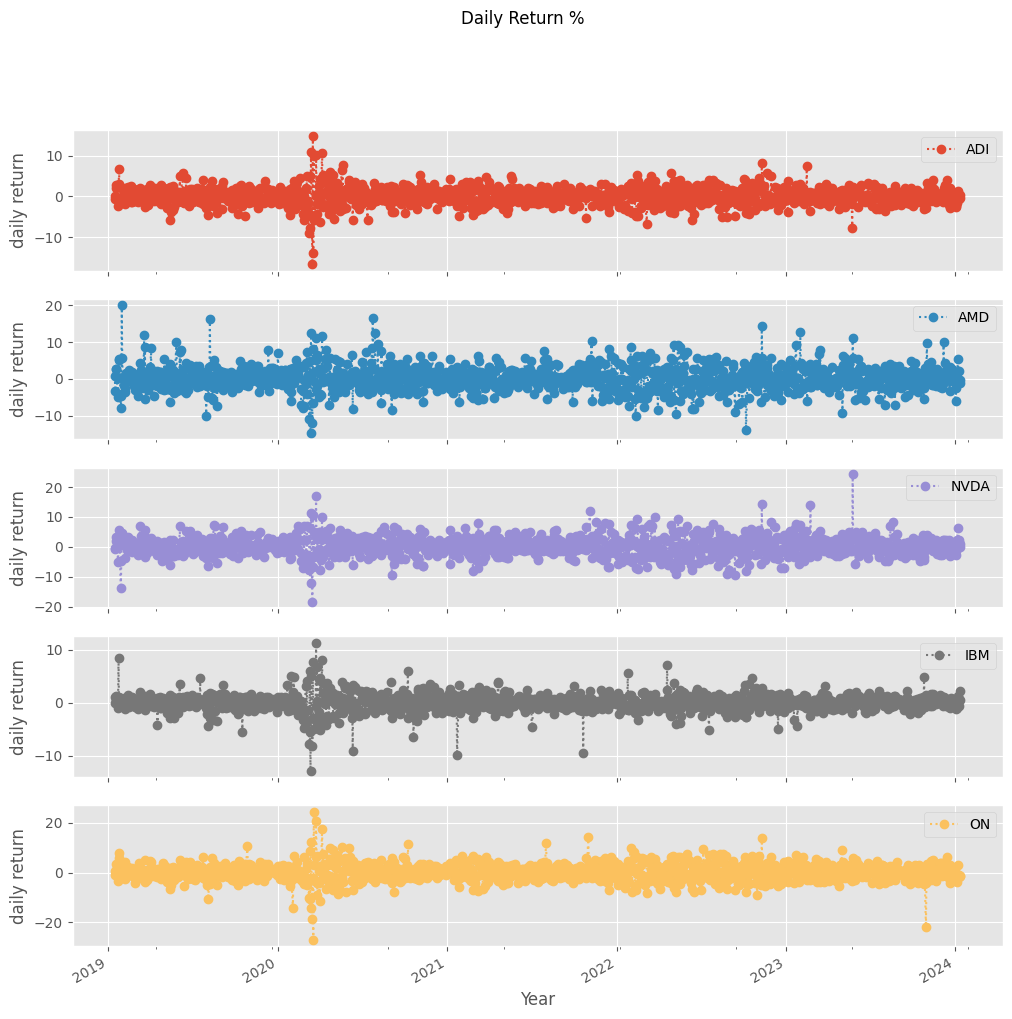

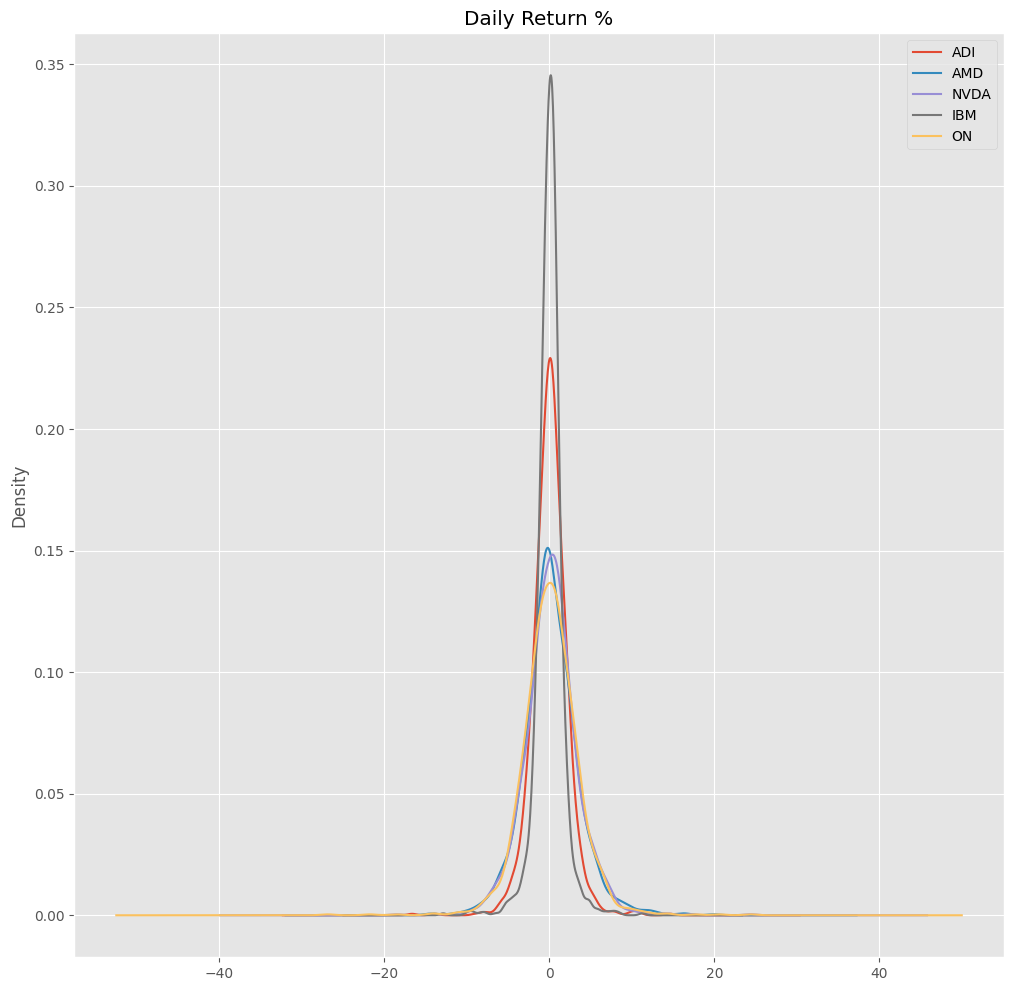

In [81]:
for stock in stocks_list:
    df['Daily Return', stock] = df['Adj Close', stock].pct_change()*100
df['Daily Return'].plot(title='Daily Return %', xlabel='Year', ylabel='daily return',figsize=(12,12),legend=True,subplots=True,linestyle=':',marker='o')
plt.show()
df['Daily Return'].plot.kde(title='Daily Return %', xlabel='Year', ylabel='daily return',figsize=(12,12),legend=True)
plt.show()

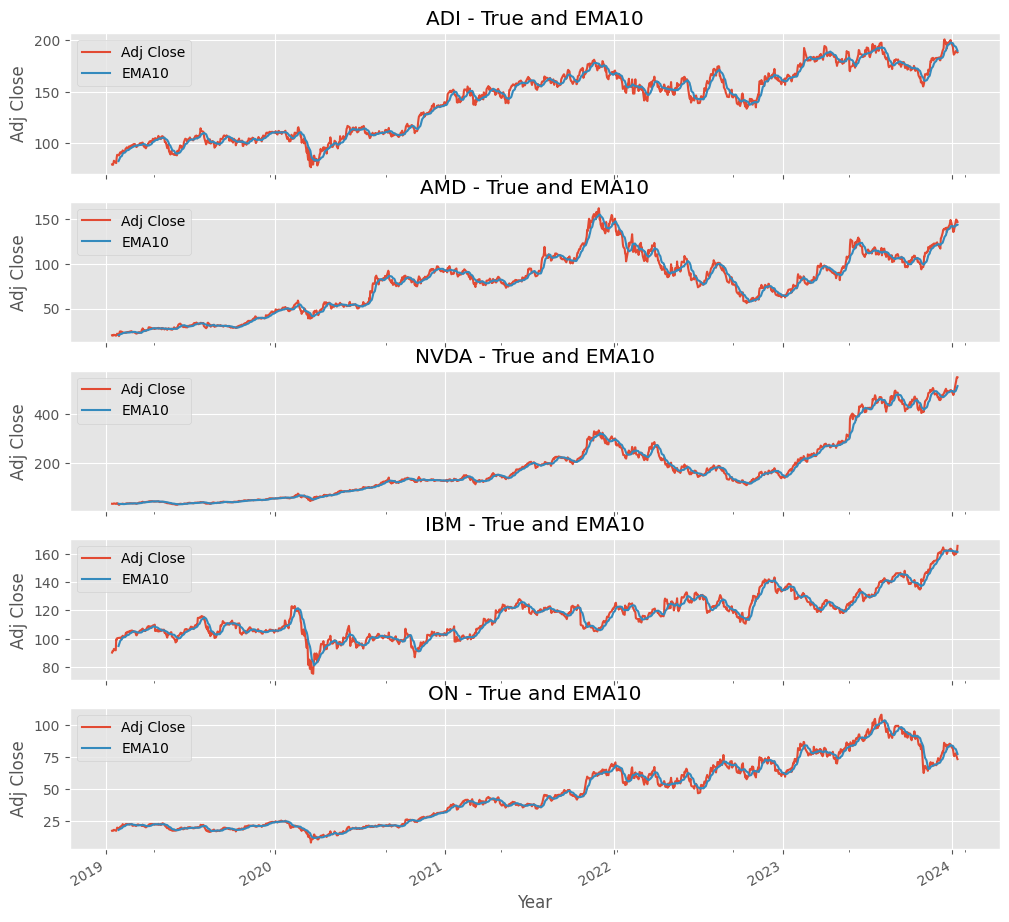

In [8]:
fig, axes = plt.subplots(nrows=len(stocks_list), ncols=1, figsize=(12, 5 * len(stocks_list)), sharex=True)

for i, stock in enumerate(stocks_list):
    df['EMA10', stock] = df['Adj Close', stock].rolling(10).mean()
    # Plot 'Adj Close' and EMA10 for each stock in separate subplots
    df_plot = df[[('Adj Close', stock), ('EMA10', stock)]]
    ax = df_plot.plot(ax=axes[i], ylabel='Adj Close', xlabel='Year', legend=False,title=f'{stock} - True and EMA10', figsize=(12, 12))

    lines, labels = ax.get_legend_handles_labels()
    labels = ['Adj Close', 'EMA10']
    ax.legend(lines, labels)


## Training
We will begin by splitting the dataset into training/validation and testing data. Then we can begin training the model using a CNN, and pass the results to LSTM layers. 

In [35]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size - 1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2

model = tf.keras.Sequential()

# CNN 
model.add(TimeDistributed(Conv1D(64, kernel_size=5, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=5, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=5, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))

# LSTM 
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model.fit(train_X[128:len(train_X)-1], train_Y[128:len(train_Y)-1], validation_data=(train_X[0:128],train_Y[0:128]), epochs=24, batch_size=60)

Epoch 1/24
14/14 [==============================] - 7s 127ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 2/24
14/14 [==============================] - 0s 31ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 3/24
14/14 [==============================] - 0s 32ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 4/24
14/14 [==============================] - 0s 28ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/24
14/14 [==============================] - 0s 36ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 6/24
14/14 [==============================] - 0s 29ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/24
14/14 [==============================] - 0s 29ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/24
14/14 [==============================] - 0s 30ms/step - loss: 0.0012 - 

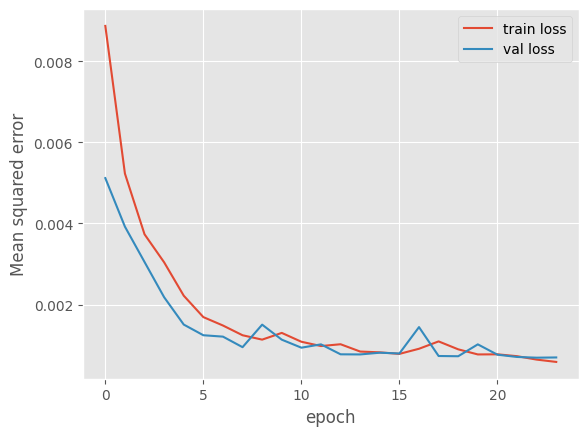

In [38]:
plt.plot(history.history['mse'], label='train loss')
plt.plot(history.history['val_mse'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Mean squared error") #MSE chosen over MAE since few outliers in dataset
plt.legend()

## Testing
We can now use the testing (never before seen) data to evaluate the model.

8/8 [==============================] - 0s 5ms/step


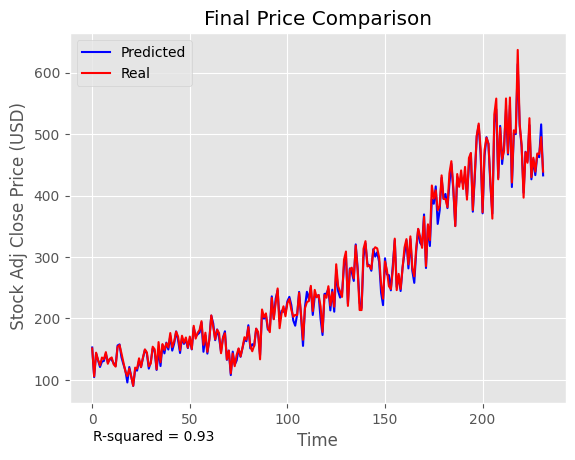

In [41]:
train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)


model.evaluate(test_X, test_Y)
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)


# Calculate R-squared
r2 = r2_score(test_label, predicted)

predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = df.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp

plt.plot(predicted, color = 'blue', label = 'Predicted')
plt.plot(test_label, color = 'red', label = 'Real')
plt.title('Final Price Comparison')
plt.xlabel('Time')
plt.text(0.6, 0.5, 'R-squared = %0.2f' % r2)
plt.ylabel(' Stock Adj Close Price (USD)')
plt.legend()
plt.show()